```{raw} html
<div id="qe-notebook-header" align="right" style="text-align:right;">
        <a href="https://quantecon.org/" title="quantecon.org">
                <img style="width:250px;display:inline;" width="250px" src="https://assets.quantecon.org/img/qe-menubar-logo.svg" alt="QuantEcon">
        </a>
</div>
```

# Inventory Dynamics

```{index} single: Markov process, inventory
```

```{contents} Contents
:depth: 2
```

## Overview

In this lecture we will study the time path of inventories for firms that
follow so-called s-S inventory dynamics.

Such firms

1. wait until inventory falls below some level $s$ and then
1. order sufficient quantities to bring their inventory back up to capacity $S$.

These kinds of policies are common in practice and also optimal in certain circumstances.

A review of early literature and some macroeconomic implications can be found in {cite}`caplin1985variability`.

Here our main aim is to learn more about simulation, time series and Markov dynamics.

While our Markov environment and many of the concepts we consider are related to those found in our {doc}`lecture on finite Markov chains <finite_markov>`, the state space is a continuum in the current application.

Let's start with some imports

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (11, 5)  #set default figure size
import numpy as np
from numba import njit, float64, prange
from numba.experimental import jitclass

## Sample Paths

Consider a firm with inventory $X_t$.

The firm waits until $X_t \leq s$ and then restocks up to $S$ units.

It faces stochastic demand $\{ D_t \}$, which we assume is IID.

With notation $a^+ := \max\{a, 0\}$, inventory dynamics can be written
as

$$
X_{t+1} =
    \begin{cases}
      ( S - D_{t+1})^+ & \quad \text{if } X_t \leq s \\
      ( X_t - D_{t+1} )^+ &  \quad \text{if } X_t > s
    \end{cases}
$$

In what follows, we will assume that each $D_t$ is lognormal, so that

$$
D_t = \exp(\mu + \sigma Z_t)
$$

where $\mu$ and $\sigma$ are parameters and $\{Z_t\}$ is IID
and standard normal.

Here's a class that stores parameters and generates time paths for inventory.

In [2]:
firm_data = [
   ('s', float64),          # restock trigger level
   ('S', float64),          # capacity
   ('mu', float64),         # shock location parameter
   ('sigma', float64)       # shock scale parameter
]


@jitclass(firm_data)
class Firm:

    def __init__(self, s=10, S=100, mu=1.0, sigma=0.5):

        self.s, self.S, self.mu, self.sigma = s, S, mu, sigma

    def update(self, x):
        "Update the state from t to t+1 given current state x."

        Z = np.random.randn()
        D = np.exp(self.mu + self.sigma * Z)
        if x <= self.s:
            return max(self.S - D, 0)
        else:
            return max(x - D, 0)

    def sim_inventory_path(self, x_init, sim_length):

        X = np.empty(sim_length)
        X[0] = x_init

        for t in range(sim_length-1):
            X[t+1] = self.update(X[t])
        return X

Let's run a first simulation, of a single path:

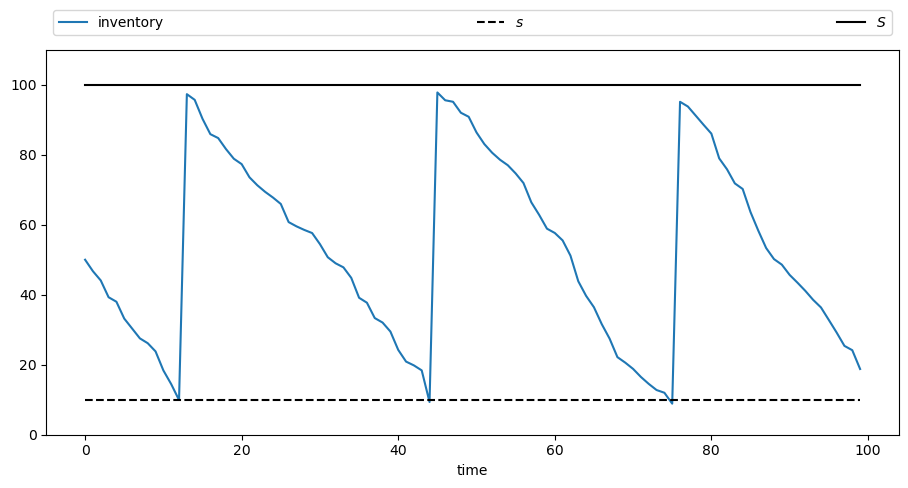

In [3]:
firm = Firm()

s, S = firm.s, firm.S
sim_length = 100
x_init = 50

X = firm.sim_inventory_path(x_init, sim_length)

fig, ax = plt.subplots()
bbox = (0., 1.02, 1., .102)
legend_args = {'ncol': 3,
               'bbox_to_anchor': bbox,
               'loc': 3,
               'mode': 'expand'}

ax.plot(X, label="inventory")
ax.plot(np.full(sim_length, s), 'k--', label="$s$")
ax.plot(np.full(sim_length, S), 'k-', label="$S$")
ax.set_ylim(0, S+10)
ax.set_xlabel("time")
ax.legend(**legend_args)

plt.show()

Now let's simulate multiple paths in order to build a more complete picture of
the probabilities of different outcomes:

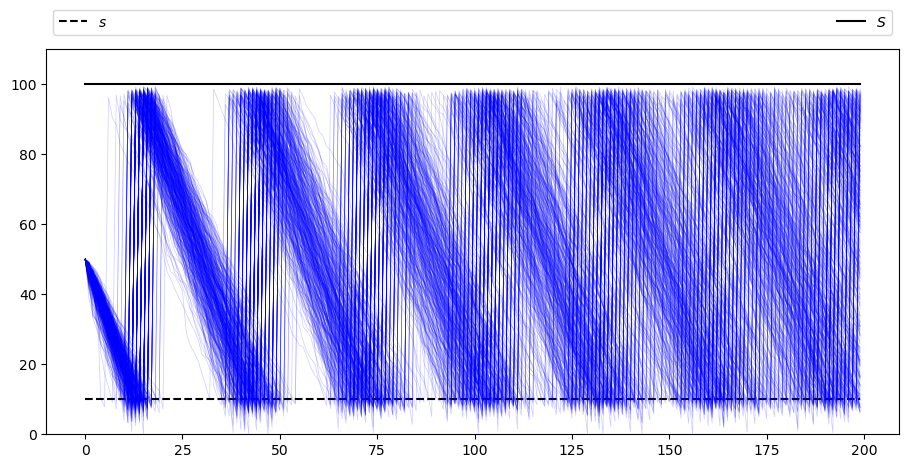

In [4]:
sim_length=200
fig, ax = plt.subplots()

ax.plot(np.full(sim_length, s), 'k--', label="$s$")
ax.plot(np.full(sim_length, S), 'k-', label="$S$")
ax.set_ylim(0, S+10)
ax.legend(**legend_args)

for i in range(400):
    X = firm.sim_inventory_path(x_init, sim_length)
    ax.plot(X, 'b', alpha=0.2, lw=0.5)

plt.show()

## Marginal Distributions

Now let’s look at the marginal distribution $\psi_T$ of $X_T$ for some
fixed $T$.

We will do this by generating many draws of $X_T$ given initial
condition $X_0$.

With these draws of $X_T$ we can build up a picture of its distribution $\psi_T$.

Here's one visualization, with $T=50$.

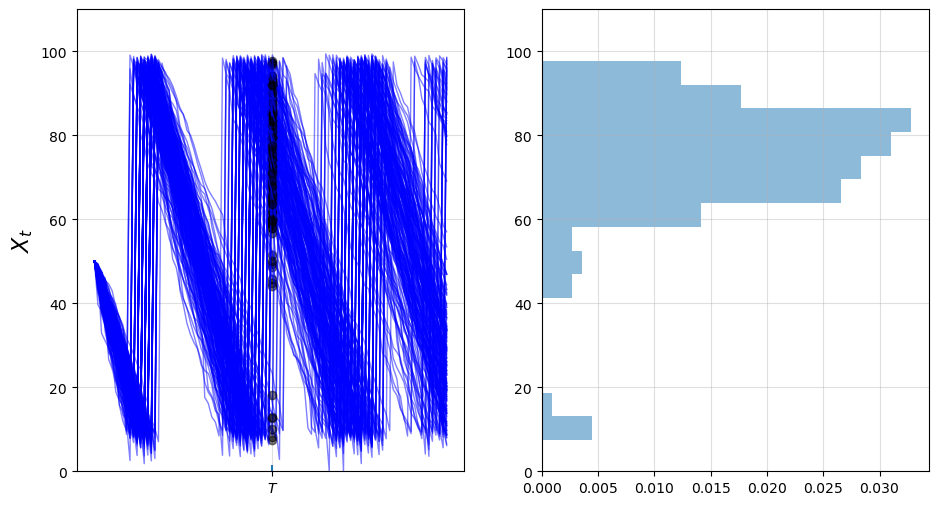

In [5]:
T = 50
M = 200  # Number of draws

ymin, ymax = 0, S + 10

fig, axes = plt.subplots(1, 2, figsize=(11, 6))

for ax in axes:
    ax.grid(alpha=0.4)

ax = axes[0]

ax.set_ylim(ymin, ymax)
ax.set_ylabel('$X_t$', fontsize=16)
ax.vlines((T,), -1.5, 1.5)

ax.set_xticks((T,))
ax.set_xticklabels((r'$T$',))

sample = np.empty(M)
for m in range(M):
    X = firm.sim_inventory_path(x_init, 2 * T)
    ax.plot(X, 'b-', lw=1, alpha=0.5)
    ax.plot((T,), (X[T+1],), 'ko', alpha=0.5)
    sample[m] = X[T+1]

axes[1].set_ylim(ymin, ymax)

axes[1].hist(sample,
             bins=16,
             density=True,
             orientation='horizontal',
             histtype='bar',
             alpha=0.5)

plt.show()

We can build up a clearer picture by drawing more samples

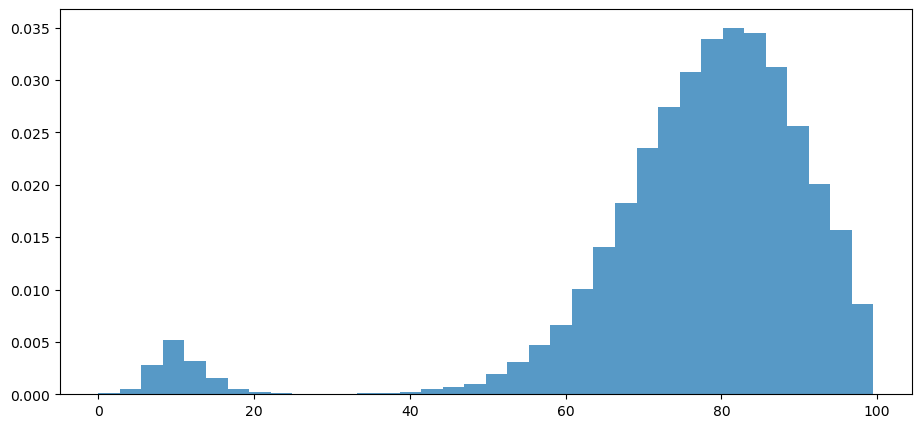

In [6]:
T = 50
M = 50_000

fig, ax = plt.subplots()

sample = np.empty(M)
for m in range(M):
    X = firm.sim_inventory_path(x_init, T+1)
    sample[m] = X[T]

ax.hist(sample,
         bins=36,
         density=True,
         histtype='bar',
         alpha=0.75)

plt.show()

Note that the distribution is bimodal

* Most firms have restocked twice but a few have restocked only once (see figure with paths above).
* Firms in the second category have lower inventory.

We can also approximate the distribution using a [kernel density estimator](https://en.wikipedia.org/wiki/Kernel_density_estimation).

Kernel density estimators can be thought of as smoothed histograms.

They are preferable to histograms when the distribution being estimated is likely to be smooth.

We will use a kernel density estimator from [scikit-learn](https://scikit-learn.org/stable/)

In [7]:
from sklearn.neighbors import KernelDensity

def plot_kde(sample, ax, label=''):

    xmin, xmax = 0.9 * min(sample), 1.1 * max(sample)
    xgrid = np.linspace(xmin, xmax, 200)
    kde = KernelDensity(kernel='gaussian').fit(sample[:, None])
    log_dens = kde.score_samples(xgrid[:, None])

    ax.plot(xgrid, np.exp(log_dens), label=label)

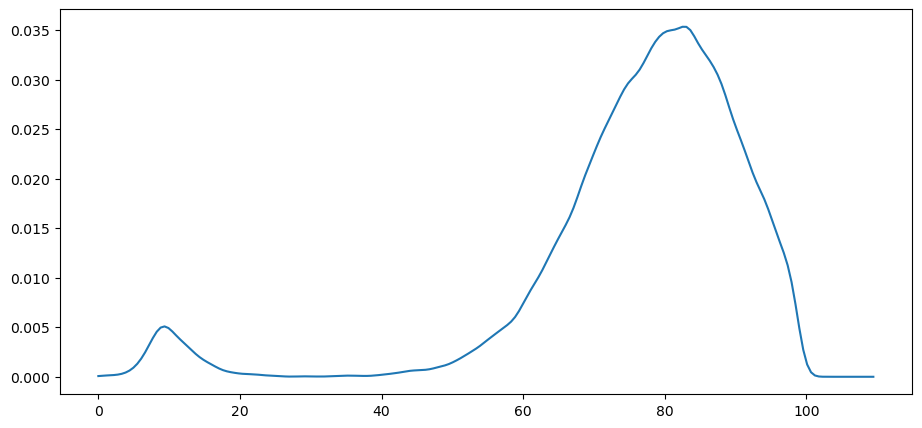

In [8]:
fig, ax = plt.subplots()
plot_kde(sample, ax)
plt.show()

The allocation of probability mass is similar to what was shown by the
histogram just above.

## Exercises

```{exercise}
:label: id_ex1

This model is asymptotically stationary, with a unique stationary
distribution.

(See the discussion of stationarity in {doc}`our lecture on AR(1) processes <ar1_processes>` for background --- the fundamental concepts are the same.)

In particular, the sequence of marginal distributions $\{\psi_t\}$
is converging to a unique limiting distribution that does not depend on
initial conditions.

Although we will not prove this here, we can investigate it using simulation.

Your task is to generate and plot the sequence $\{\psi_t\}$ at times
$t = 10, 50, 250, 500, 750$ based on the discussion above.

(The kernel density estimator is probably the best way to present each
distribution.)

You should see convergence, in the sense that differences between successive distributions are getting smaller.

Try different initial conditions to verify that, in the long run, the distribution is invariant across initial conditions.
```

```{solution-start} id_ex1
:class: dropdown
```

Below is one possible solution:

The computations involve a lot of CPU cycles so we have tried to write the
code efficiently.

This meant writing a specialized function rather than using the class above.

In [9]:
s, S, mu, sigma = firm.s, firm.S, firm.mu, firm.sigma

@njit(parallel=True)
def shift_firms_forward(current_inventory_levels, num_periods):

    num_firms = len(current_inventory_levels)
    new_inventory_levels = np.empty(num_firms)

    for f in prange(num_firms):
        x = current_inventory_levels[f]
        for t in range(num_periods):
            Z = np.random.randn()
            D = np.exp(mu + sigma * Z)
            if x <= s:
                x = max(S - D, 0)
            else:
                x = max(x - D, 0)
        new_inventory_levels[f] = x

    return new_inventory_levels

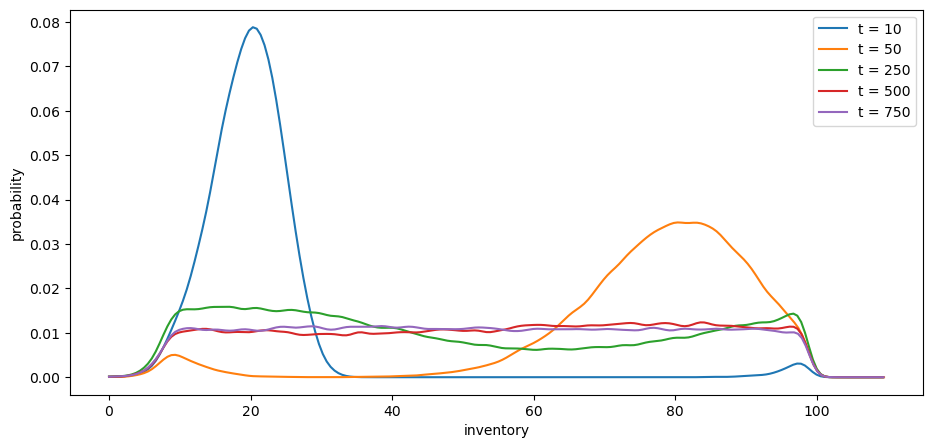

In [10]:
x_init = 50
num_firms = 50_000

sample_dates = 0, 10, 50, 250, 500, 750

first_diffs = np.diff(sample_dates)

fig, ax = plt.subplots()

X = np.full(num_firms, x_init)

current_date = 0
for d in first_diffs:
    X = shift_firms_forward(X, d)
    current_date += d
    plot_kde(X, ax, label=f't = {current_date}')

ax.set_xlabel('inventory')
ax.set_ylabel('probability')
ax.legend()
plt.show()

Notice that by $t=500$ or $t=750$ the densities are barely
changing.

We have reached a reasonable approximation of the stationary density.

You can convince yourself that initial conditions don’t matter by
testing a few of them.

For example, try rerunning the code above will all firms starting at
$X_0 = 20$ or $X_0 = 80$.

```{solution-end}
```

```{exercise}
:label: id_ex2

Using simulation, calculate the probability that firms that start with
$X_0 = 70$ need to order twice or more in the first 50 periods.

You will need a large sample size to get an accurate reading.
```


```{solution-start} id_ex2
:class: dropdown
```

Here is one solution.

Again, the computations are relatively intensive so we have written a a
specialized function rather than using the class above.

We will also use parallelization across firms.

In [11]:
@njit(parallel=True)
def compute_freq(sim_length=50, x_init=70, num_firms=1_000_000):

    firm_counter = 0  # Records number of firms that restock 2x or more
    for m in prange(num_firms):
        x = x_init
        restock_counter = 0  # Will record number of restocks for firm m

        for t in range(sim_length):
            Z = np.random.randn()
            D = np.exp(mu + sigma * Z)
            if x <= s:
                x = max(S - D, 0)
                restock_counter += 1
            else:
                x = max(x - D, 0)

        if restock_counter > 1:
            firm_counter += 1

    return firm_counter / num_firms

Note the time the routine takes to run, as well as the output.

In [12]:
%%time

freq = compute_freq()
print(f"Frequency of at least two stock outs = {freq}")

Frequency of at least two stock outs = 0.447621
CPU times: user 4.16 s, sys: 18.2 ms, total: 4.18 s
Wall time: 1.16 s


Try switching the `parallel` flag to `False` in the jitted function
above.

Depending on your system, the difference can be substantial.

(On our desktop machine, the speed up is by a factor of 5.)

```{solution-end}
```